In [ ]:
# @title Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib


In [ ]:
# @title Dados pré-processados

train_df = pd.read_csv('/content/train_Sleep_health_and_lifestyle_dataset.csv')
val_df = pd.read_csv('/content/val_Sleep_health_and_lifestyle_dataset.csv')
test_df = pd.read_csv('/content/test_Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
# @title Separar variáveis features do alvo

X_train, y_train = train_df.drop(columns=['Quality of Sleep']), train_df['Quality of Sleep']
X_val, y_val = val_df.drop(columns=['Quality of Sleep']), val_df['Quality of Sleep']
X_test, y_test = test_df.drop(columns=['Quality of Sleep']), test_df['Quality of Sleep']

In [ ]:
# @title Refinamento
cols_to_drop = [
    'Gender_Male',
    'Occupation_Accountant',
    'Sleep Disorder_Normal',
    'BP_Category',
    'BMI Category',
    'Heart Rate'
]

X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns])
X_val = X_val.drop(columns=[c for c in cols_to_drop if c in X_val.columns])
X_test = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns])

print(f"Variáveis restantes: {len(X_train.columns)}")

Variáveis restantes: 18


In [ ]:
# @title Regressão Linear

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# @title Teste de Multicolinearidade - VIF

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns

    # Calculando o VIF para cada variável
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data.sort_values(by="VIF", ascending=False)

vif_df = calculate_vif(X_train)
print("Análise de Multicolinearidade (VIF):")
print()
print(vif_df)
print()

print("VIF > 5: Indica alta correlação")

Análise de Multicolinearidade (VIF):

                            Feature       VIF
3                      Stress Level  8.802360
1                    Sleep Duration  8.790435
5                     Gender_Female  6.174431
17       Sleep Disorder_Sleep Apnea  4.967996
0                               Age  4.802629
4                       Daily Steps  4.783779
2           Physical Activity Level  4.357007
11  Occupation_Sales Representative  3.927919
10                 Occupation_Nurse  3.847456
16          Sleep Disorder_Insomnia  3.527292
13             Occupation_Scientist  2.725354
15               Occupation_Teacher  2.375349
9                Occupation_Manager  2.324632
12           Occupation_Salesperson  2.077417
7               Occupation_Engineer  1.719312
6                 Occupation_Doctor  1.716479
14     Occupation_Software Engineer  1.589429
8                 Occupation_Lawyer  1.321338

VIF > 5: Indica alta correlação


In [ ]:
# @title Exportação para o Dashboard

joblib.dump(lr_model, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

In [ ]:
# @title Validação Cruzada

X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

cv_scores = cross_val_score(lr_model, X_full_train, y_full_train, cv=5, scoring='r2')

print(f"Resultados de cada Fold: {cv_scores}")
print(f"R² Médio (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Resultados de cada Fold: [0.93732509 0.92943724 0.96599359 0.88633178 0.90060062]
R² Médio (CV): 0.9239 (+/- 0.0281)


In [ ]:
# @title Avaliação Completa

def evaluate_model(model, X, y, set_name="Validação"):
    preds = model.predict(X)

    metrics = {
        "R² - Precisão": r2_score(y, preds),
        "MAE - Erro Médio": mean_absolute_error(y, preds),
        "RMSE - Erro Quadrático": np.sqrt(mean_squared_error(y, preds)),
        "MedAE - Erro Típico": median_absolute_error(y, preds)
    }

    print(f"Métricas - {set_name}: ")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return preds

preds_val = evaluate_model(lr_model, X_val, y_val, "Validação")
print()
preds_test = evaluate_model(lr_model, X_test, y_test, "Teste Final")

Métricas - Validação: 
R² - Precisão: 0.9517
MAE - Erro Médio: 0.1919
RMSE - Erro Quadrático: 0.2688
MedAE - Erro Típico: 0.1361

Métricas - Teste Final: 
R² - Precisão: 0.9543
MAE - Erro Médio: 0.1886
RMSE - Erro Quadrático: 0.2557
MedAE - Erro Típico: 0.1664


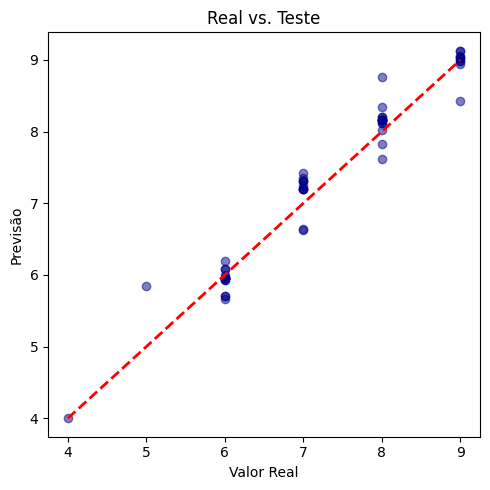

In [ ]:
# @title Gráficos de Diagnóstico

plt.figure(figsize=(5, 5))

# 1. Real vs Predito
plt.scatter(y_test, preds_test, alpha=0.5, color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Real vs. Teste')
plt.xlabel('Valor Real')
plt.ylabel('Previsão')

plt.tight_layout()
plt.show()

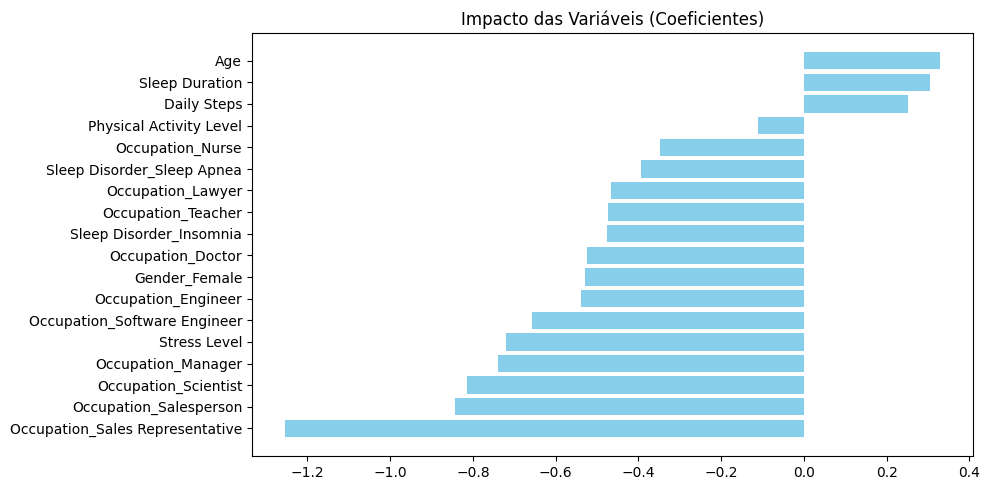

In [ ]:
# 2. Análise de Importância

plt.figure(figsize=(10, 5))

coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coef': lr_model.coef_})
coef_df = coef_df.sort_values(by='Coef', ascending=True)
plt.barh(coef_df['Feature'], coef_df['Coef'], color='skyblue')
plt.title('Impacto das Variáveis (Coeficientes)')

plt.tight_layout()
plt.show()

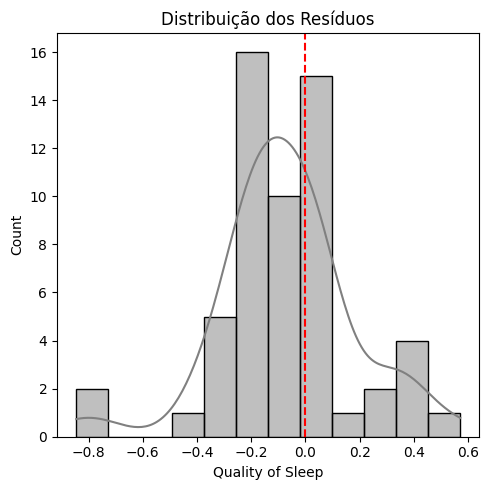

In [ ]:
# 3. Distribuição de Erros - Resíduos

plt.figure(figsize=(5, 5))

residuals = y_test - preds_test
sns.histplot(residuals, kde=True, color='gray')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribuição dos Resíduos')

plt.tight_layout()
plt.show()

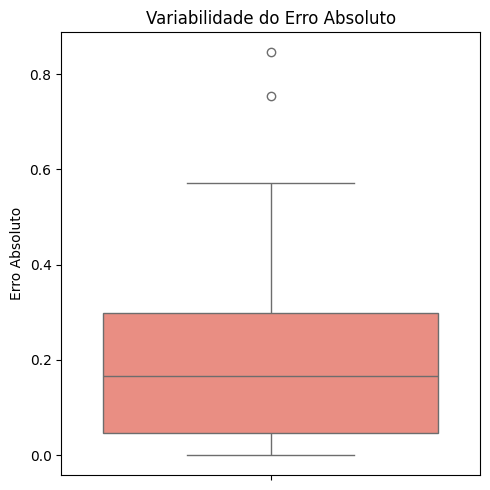

In [ ]:
# 4. Erros Absolutos

plt.figure(figsize=(5, 5))

abs_errors = np.abs(y_test - preds_test)
sns.boxplot(y=abs_errors, color='salmon')
plt.title('Variabilidade do Erro Absoluto')
plt.ylabel('Erro Absoluto')

plt.tight_layout()
plt.show()

In [ ]:
df_metrics = pd.DataFrame({
    'Métrica': ['R²', 'MAE', 'RMSE', 'MedAE'],
    'Validação': [0.9517, 0.1919, 0.2688, 0.1361],
    'Teste Final': [0.9543, 0.1886, 0.2557, 0.1664]
})

print("Comparativo de Performance:")
print()
print(df_metrics)

Comparativo de Performance:

  Métrica  Validação  Teste Final
0      R²     0.9517       0.9543
1     MAE     0.1919       0.1886
2    RMSE     0.2688       0.2557
3   MedAE     0.1361       0.1664
